###  1. Imports

In [1]:
import os
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
import praw
from dotenv import load_dotenv
import pickle

load_dotenv()

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
ps = nltk.PorterStemmer()
from nltk.tokenize import word_tokenize

import re

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import metrics

### 2. Define functions to get subreddit posts data from Reddit and write it to files

In [2]:
user_agent = "Scraper 1.0 by /u/Alliix"
reddit = praw.Reddit(
  client_id=os.environ['CLIENT_ID'],
  client_secret=os.environ['CLIENT_SECRET'],
  user_agent=user_agent
)

In [153]:
def cleanPostsData(postsFromCsv):
#     clean posts data
    postsProcessed = []

#     RegEx
    zeroSpaceWidth = re.compile(r'&#x200B')
    urls = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', re.IGNORECASE)
    numbers = re.compile(r' \d+(\.\d+)? ')
    punctuation = re.compile(r'[^\w\d\s]')
    whitespaces = re.compile(r'\s+')
    leadTrailWhitespace = re.compile(r'^\s+|\s+?$')

    for d in postsFromCsv.Post:
        if(type(d)==str):
            x = d
            # Replace zero width space with ' '
            x = zeroSpaceWidth.sub(' ',x)
            # Replace URLs with 'url'
            x = urls.sub('url',x)
            # Replace numbers with 'nmbr'
            x = numbers.sub('nmbr',x)
            # Remove punctuation
            x = punctuation.sub(' ',x)
            # Replace whitespace between terms with ' '
            x = whitespaces.sub(' ',x)
            # Remove leading and trailing whitespace
            x = leadTrailWhitespace.sub(' ',x)

            text_tokens = word_tokenize(x)
            # Remove word stems using a Porter stemmer
            tokens_without_ws = [ps.stem(word) for word in text_tokens]
            x = (" ").join(tokens_without_ws)
            
            # remove stop words from posts
            text_tokens = word_tokenize(x)
            tokens_without_sw = [word for word in text_tokens if not word in stop_words]
            x = (" ").join(tokens_without_sw)
            postsProcessed.append(x)
        else: 
            postsProcessed.append(d)
            
    return postsProcessed


In [154]:
def getAndCleanPostsData(subreddit, postOutputFile, processedPostOutputFile):
#     get
    posts = set()
    for submission in reddit.subreddit(subreddit).new(limit=None):
        posts.add(submission)
    postsLength = len(posts)
    
#     write posts to file
    data = []
    for post in posts:
        data.append({'Author': post.author, 'Subreddit': post.subreddit, 'Date': post.created_utc, 'Title': post.title, 'Post': post.selftext})    
    postsData = pd.DataFrame(data, columns=['Author', 'Subreddit', 'Date', 'Title', 'Post'])
    postsData.to_csv(postOutputFile, index=False)
    
    postsFromCsv = pd.read_csv(postOutputFile)
    postsProcessed = cleanPostsData(postsFromCsv)
    
#     write processed posts data to file
    processedData = []
    for i in range(0, postsLength):
        processedData.append({'Author': postsFromCsv.Author[i], 'Subreddit': postsFromCsv.Subreddit[i], 'Date': postsFromCsv.Date[i], 'Title': postsFromCsv.Title[i], 'Post': postsProcessed[i]})

    postsData = pd.DataFrame(processedData, columns=['Author', 'Subreddit', 'Date', 'Title', 'Post'])
    postsData.to_csv(processedPostOutputFile, index=False)
    
    return postsLength

### 3. Run the functions to get data from subreddits

In [155]:
# r/depression
depressedPostsLength = getAndCleanPostsData('depression', 'depressed_posts.csv', 'depressed_posts_processed.csv')
print(depressedPostsLength)

998


In [156]:
# r/unpopularopinion
unpopularopinionPostsLength = getAndCleanPostsData('unpopularopinion', 'unpopularopinion_posts.csv', 'unpopularopinion_posts_processed.csv')
print(unpopularopinionPostsLength)

988


In [157]:
# r/lonely
lonelyPostsLength = getAndCleanPostsData('lonely', 'lonely_posts.csv', 'lonely_posts_processed.csv')
print(lonelyPostsLength)

980


In [158]:
# r/MachineLearning
machinelearningPostsLength = getAndCleanPostsData('machinelearning', 'machinelearning_posts.csv', 'machinelearning_posts_processed.csv')
print(machinelearningPostsLength)

972


In [159]:
posts = pd.read_csv('depressed_posts_processed.csv')
posts.head()

,Author,Subreddit,Date,Title,Post
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,english second languag sorri made mistak watch...
1,iSlurpees,depression,1.620602e+09,Is this depression,felt top world friday night everyth wa go feel...
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,hi everyon realli want hear anyon ha experi wh...
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,make super depress noth go back job gone scare...
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,25f gon na turnnmbron 15th may suffer sever de...


### 4. Generating Features function
Features will be the most common words in posts.

In [3]:
def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

### 5. Generate Word Frequency for Subreddits

In [4]:
# r/depression
depressionFreqWords = getWordFrequency('depressed_posts_processed.csv')

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(depressionFreqWords)))
print('Most common words: {}'.format(depressionFreqWords.most_common(100)))

Number of words: 6766
Most common words: [('feel', 1531), ('wa', 1403), ('thi', 1302), ('like', 1274), ('want', 918), ('get', 877), ('know', 824), ('becaus', 786), ('life', 740), ('depress', 673), ('even', 666), ('time', 639), ('go', 592), ('thing', 526), ('think', 507), ('make', 500), ('realli', 496), ('peopl', 493), ('day', 486), ('tri', 458), ('friend', 445), ('one', 443), ('would', 430), ('never', 394), ('year', 367), ('work', 363), ('start', 359), ('onli', 353), ('help', 351), ('much', 350), ('ha', 348), ('live', 347), ('thought', 313), ('good', 304), ('talk', 299), ('still', 295), ('fuck', 294), ('say', 293), ('anyth', 292), ('take', 291), ('alway', 287), ('back', 281), ('ani', 280), ('whi', 275), ('way', 274), ('everyth', 271), ('see', 271), ('got', 267), ('noth', 265), ('bad', 256), ('love', 252), ('someth', 249), ('hate', 248), ('job', 247), ('happi', 243), ('need', 242), ('tell', 241), ('anyon', 240), ('better', 240), ('could', 239), ('anymor', 235), ('end', 232), ('someon', 

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


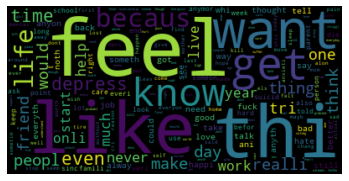

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = depressionFreqWords
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

In [162]:
# r/unpopularopinion
unpopularopinionFreqWords = getWordFrequency('unpopularopinion_posts_processed.csv')

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(unpopularopinionFreqWords)))
print('Most common words: {}'.format(unpopularopinionFreqWords.most_common(15)))

Number of words: 8630
Most common words: [('peopl', 919), ('like', 889), ('thi', 795), ('get', 583), ('becaus', 495), ('make', 451), ('wa', 427), ('think', 410), ('one', 398), ('want', 355), ('say', 349), ('time', 347), ('thing', 340), ('even', 335), ('go', 309)]


In [163]:
# r/lonely
lonelyFreqWords = getWordFrequency('lonely_posts_processed.csv')

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(lonelyFreqWords)))
print('Most common words: {}'.format(lonelyFreqWords.most_common(15)))

Number of words: 6037
Most common words: [('feel', 1133), ('like', 1084), ('wa', 1043), ('thi', 1002), ('friend', 987), ('want', 791), ('peopl', 751), ('get', 645), ('talk', 602), ('one', 592), ('know', 584), ('go', 572), ('time', 571), ('life', 546), ('becaus', 535)]


In [164]:
# r/machinelearning
machinelearningFreqWords = getWordFrequency('machinelearning_posts_processed.csv')

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(machinelearningFreqWords)))
print('Most common words: {}'.format(machinelearningFreqWords.most_common(15)))

Number of words: 8454
Most common words: [('url', 1820), ('thi', 1131), ('model', 942), ('use', 881), ('learn', 671), ('data', 573), ('train', 495), ('paper', 428), ('like', 403), ('work', 365), ('would', 362), ('ani', 350), ('imag', 302), ('one', 301), ('make', 300)]


### 6. Generate features for all posts
We will tokenize each word and will use the 1500 most common words as features.

In [39]:
# Save all posts to one file

depressedData = pd.read_csv('depressed_posts_processed.csv')
unpopularopinionData = pd.read_csv('unpopularopinion_posts_processed.csv')
lonelyData = pd.read_csv('lonely_posts_processed.csv')
machinelearningData = pd.read_csv('machinelearning_posts_processed.csv')

allPosts = depressedData.append(unpopularopinionData).append(lonelyData).append(machinelearningData)

allPosts.to_csv('all_posts_processed.csv', index=False)

depression          998
unpopularopinion    988
lonely              980
MachineLearning     972
Name: Subreddit, dtype: int64


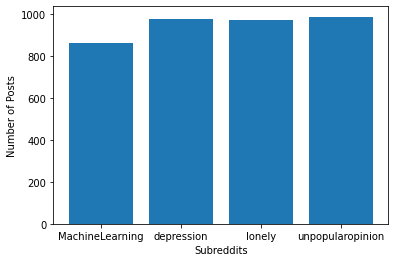

In [40]:
# check subreddit distribution
import matplotlib.pyplot as plt
subreddits = allPosts.Subreddit
print(subreddits.value_counts())

Subreddit_count=allPosts.groupby('Subreddit').count()
plt.bar(Subreddit_count.index.values, Subreddit_count['Post'])
plt.xlabel('Subreddits')
plt.ylabel('Number of Posts')
plt.show()

In [9]:
all_words_combined = getWordFrequency('all_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(all_words_combined)))
print('Most common words: {}'.format(all_words_combined.most_common(100)))

Number of words: 18661
Most common words: [('thi', 4230), ('like', 3650), ('wa', 3139), ('feel', 3013), ('peopl', 2293), ('get', 2282), ('want', 2248), ('becaus', 1920), ('url', 1865), ('know', 1859), ('time', 1831), ('one', 1734), ('make', 1727), ('even', 1650), ('go', 1573), ('friend', 1541), ('would', 1500), ('life', 1497), ('use', 1475), ('think', 1450), ('thing', 1350), ('realli', 1297), ('tri', 1230), ('ha', 1154), ('work', 1136), ('day', 1109), ('ani', 1074), ('talk', 1072), ('onli', 1012), ('much', 993), ('someon', 965), ('say', 962), ('model', 958), ('never', 955), ('way', 922), ('good', 892), ('see', 889), ('need', 871), ('year', 863), ('depress', 840), ('also', 829), ('whi', 824), ('help', 819), ('learn', 819), ('someth', 805), ('person', 802), ('look', 789), ('love', 787), ('start', 785), ('live', 762), ('could', 760), ('still', 737), ('alway', 726), ('take', 717), ('anyon', 696), ('better', 687), ('find', 651), ('veri', 650), ('got', 638), ('thought', 626), ('anyth', 619),

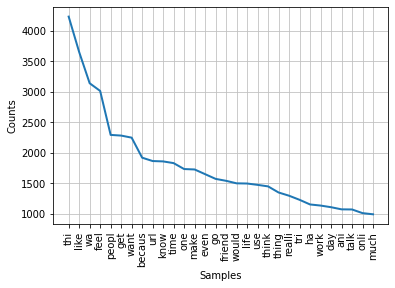

In [90]:
import matplotlib.pyplot as plt
all_words_combined.plot(30,cumulative=False)
plt.show()

### 7. FindFeatures fuction
function will determine which of the 1500 word features are contained in the post

In [11]:
# we will use the 1500 most common words as features

word_features = list(all_words_combined.keys())[:1500]

In [16]:
def find_features(post):
    words = word_tokenize(post)
    features = {}
    for word in word_features:
        features[word] = (word in words)
    return features

In [170]:
# example
posts = pd.read_csv('all_posts_processed.csv')

features = find_features(posts.Post[1])
for key, value in features.items():
    if value == True:
        print(key)

like
go
back
keep
life
top
world
friday
night
everyth
wa
feel
low
put
act
whenev
peopl
let
get
walk
care
ask
would
come
home
drink
stop
becaus
make
parti
hour
small
alon
thought
start
felt


### 6. Save training, testing data

In [27]:
Y = []
postsArr = []
i = 0 
for post in posts.Post:
    if(type(post)==str):
        postsArr.append(post)
        Y.append(posts.Subreddit[i])
    i+=1
    
# Now find features for all posts
posts_all = list(zip(postsArr, Y))

# define a seed for reproducibility
seed = 1
np.random.seed = seed
np.random.shuffle(posts_all)

# call find_features function for each post
featuresets = [(find_features(text), label) for (text, label) in posts_all]

In [28]:
# we can split the featuresets into training and testing datasets using sklearn
from sklearn import model_selection

# split the data into training and testing datasets
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

print(len(posts))
print(len(training))
print(len(testing))

3938
2849
950


### 7. Scikit-Learn Classifiers with NLTK

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 39.26315789473684
Decision Tree Accuracy: 60.94736842105263
Random Forest Accuracy: 75.68421052631578
Logistic Regression Accuracy: 76.52631578947368
SGD Classifier Accuracy: 74.94736842105263
Naive Bayes Accuracy: 79.78947368421052
SVM Linear Accuracy: 73.57894736842105


In [31]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 73.57894736842105


In [32]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

In [33]:
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual','actual', 'actual'], ['depression', 'unpopularopinion', 'lonely', 'MachineLearning']],
    columns = [['predicted', 'predicted','predicted', 'predicted'], ['depression', 'unpopularopinion', 'lonely', 'MachineLearning']])

                  precision    recall  f1-score   support

 MachineLearning       0.86      0.92      0.89       224
      depression       0.72      0.72      0.72       236
          lonely       0.71      0.75      0.73       249
unpopularopinion       0.88      0.76      0.82       241

        accuracy                           0.79       950
       macro avg       0.79      0.79      0.79       950
    weighted avg       0.79      0.79      0.79       950



predicted                                        
                        depression unpopularopinion lonely MachineLearning
actual depression              207                4      8               5
       unpopularopinion          7              170     47              12
       lonely                   15               40    186               8
       MachineLearning          13               23     22             183

In [34]:
# save the model to disk
filename = 'finalized_model_subreddits.sav'
pickle.dump(nltk_ensemble, open(filename, 'wb'))

In [35]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

# make class label prediction for testing set
txt_features, labels = zip(*testing)

result = loaded_model.classify_many(txt_features)
print(classification_report(labels, result))

                  precision    recall  f1-score   support

 MachineLearning       0.86      0.92      0.89       224
      depression       0.72      0.72      0.72       236
          lonely       0.71      0.75      0.73       249
unpopularopinion       0.88      0.76      0.82       241

        accuracy                           0.79       950
       macro avg       0.79      0.79      0.79       950
    weighted avg       0.79      0.79      0.79       950



### 8. Classifier for r/depression posts only

In [12]:
all_words_combined = getWordFrequency('all_posts_processed.csv')
word_features = list(all_words_combined.keys())[:1500]

# Training, testing data
posts = pd.read_csv('all_posts_processed.csv')

Y = []
postsArr = []
i = 0 
for post in posts.Post:
    if(type(post)==str):
        postsArr.append(post)
        if(posts.Subreddit[i]=='depression'):
            Y.append(posts.Subreddit[i])
        else:
            Y.append('not r/depression')
    i+=1
    
# Now find features for all posts
posts_all = list(zip(postsArr, Y))

# define a seed for reproducibility
seed = 1
np.random.seed = seed
np.random.shuffle(posts_all)

# call find_features function for each post
featuresets = [(find_features(text), label) for (text, label) in posts_all]

In [13]:
# we can split the featuresets into training and testing datasets using sklearn
from sklearn import model_selection

# split the data into training and testing datasets
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

print(len(posts))
print(len(training))
print(len(testing))

3938
2849
950


In [15]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 76.21052631578948
Decision Tree Accuracy: 77.26315789473685
Random Forest Accuracy: 83.26315789473684
Logistic Regression Accuracy: 83.89473684210526
SGD Classifier Accuracy: 81.78947368421052
Naive Bayes Accuracy: 81.05263157894737
SVM Linear Accuracy: 80.94736842105263


In [16]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 80.94736842105263


In [17]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

In [18]:
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual'], ['depression', 'not r/depression']],
    columns = [['predicted', 'predicted'], ['depression', 'not r/depression']])

                  precision    recall  f1-score   support

      depression       0.71      0.60      0.65       224
not r/depression       0.88      0.92      0.90       726

        accuracy                           0.85       950
       macro avg       0.79      0.76      0.77       950
    weighted avg       0.84      0.85      0.84       950



predicted                 
                        depression not r/depression
actual depression              134               90
       not r/depression         56              670

### 9. Save trained data

In [19]:
# save the model to disk
filename = 'finalized_model_depression_or_not.sav'
pickle.dump(nltk_ensemble, open(filename, 'wb'))

In [21]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

# make class label prediction for testing set
txt_features, labels = zip(*testing)

result = loaded_model.classify_many(txt_features)
print(classification_report(labels, result))

                  precision    recall  f1-score   support

      depression       0.71      0.60      0.65       224
not r/depression       0.88      0.92      0.90       726

        accuracy                           0.85       950
       macro avg       0.79      0.76      0.77       950
    weighted avg       0.84      0.85      0.84       950



### 10. Classify Post

In [14]:
def CleanPost(post):
#      RegEx
    zeroSpaceWidth = re.compile(r'&#x200B')
    urls = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', re.IGNORECASE)
    numbers = re.compile(r' \d+(\.\d+)? ')
    punctuation = re.compile(r'[^\w\d\s]')
    whitespaces = re.compile(r'\s+')
    leadTrailWhitespace = re.compile(r'^\s+|\s+?$')

    x = post
    # Replace zero width space with ' '
    x = zeroSpaceWidth.sub(' ',x)
    # Replace URLs with 'url'
    x = urls.sub('url',x)
    # Replace numbers with 'nmbr'
    x = numbers.sub('nmbr',x)
    # Remove punctuation
    x = punctuation.sub(' ',x)
    # Replace whitespace between terms with ' '
    x = whitespaces.sub(' ',x)
    # Remove leading and trailing whitespace
    x = leadTrailWhitespace.sub(' ',x)

    text_tokens = word_tokenize(x)
    # Remove word stems using a Porter stemmer
    tokens_without_ws = [ps.stem(word) for word in text_tokens]
    x = (" ").join(tokens_without_ws)

    # remove stop words from posts
    text_tokens = word_tokenize(x)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    x = (" ").join(tokens_without_sw)
    
    return x

In [12]:
def ClassifyPost(post, modelFile):
    post = CleanPost(post)
    loaded_model = pickle.load(open(modelFile, 'rb'))
    
    featureset = find_features(post)
    
    result = loaded_model.classify(featureset)
    print(result)

In [17]:
testPost = "Ive always had a few mutuals at a time growing up, but never a proper close friend. Let alone that one person who feels that mutual “you are my first choice” for. Until the start of last year :) I saw her almost every single day and we knew everything about each other. We were both each others best friend and even my anxiety filled, obsessive, overthinking brain could know that for sure. I dont know what happened. I dont know what i did wrong. She started hanging out with this group of “pretty popular kids” who are really racist and big bullies. Slowly she started changing, and i could tell she just didnt want to hang out with me anymore. As painful as it was i let it happen and didnt ask to come over anymore or text her unnecessarily because the last thing i want to do is annoy her. Its hard not knowing what i did wrong and i miss being close to her. I just want her to like me again."
ClassifyPost(testPost,'finalized_model_subreddits.sav')
ClassifyPost(testPost,'finalized_model_depression_or_not.sav')

lonely
not r/depression
